# Table of Contents
- [Problem Description](#prob)    
- [Data Description](#data)    
  - [Background research](#background)    
- [Reading the Data](#read)    
  - [Reading .csv files](#readcsv)    
    - [Getting to know the data](#knowdata)    
    - [Row data selection](#rowselectioncsv)    
  - [Reading .json files](#readjson)    
    - [Getting to know the data](#knowdata2)    
    - [Row data selection](#rowselectionjson)    
- [Data Preparation](#dataprep)    
  - [Creating a dictionary](#dict)    
  - [Column data selection](#columnselection)    
  - [Data conversion](#dataconvert)    
  - [Handling missing values](#handling)    
    - [Checking for missing values](#checking)    
    - [Filling in missing values](#filling)    
      - [Demographics](#demographics)    
      - [Health](#health)    
      - [Hospitalizations](#hospitalizations)    
      - [Vaccinations](#vaccinations)    
      - [Epidemiology](#edidemiology)    
  - [Checking for outliers](#checkingoutliers)    
  - [Data grouping](#datagrouping)    
- [Combining the Datasets](#combining)    
  - [Checking for unique values](#unique)    
  - [Combining the datasets](#combining2)    
- [Finding Correlations](#correlation)    
  - [Correlation analysis](#analysis)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='prob'></a> Problem Description

The COVID-19 pandemic has had a profound impact on our daily lives and will always be remembered as a significant event in history. In this project, various datasets were examined to analyze the trend of COVID cases per country for years 2020-2022, including the impact of vaccination deployment and administration, demographics, economy, and health indicators including mortality rates, smoking and diabetes prevalence.

The main focus of this project will be on acquiring, preparing, cleaning, and aggregating data. Once these tasks have been completed for each dataset, the clean datasets are combined into a single dataset for further analysis.

***

# <a id='data'></a> Data Description

The data is sourced from the Google Health COVID-19 Open Data Repository, one of the most comprehensive collections of COVID-19-related information. 

The datasets included in this analysis are as follows:

Main datasets:
1. **epidemiology** - information about COVID-19 infections for each date and region
2. **hospitalizations** - information related to COVID-19 patients and hospitals
3. **vaccinations** - information related to deployment and administration of COVID-19 vaccines

Supplemental datasets:
1. **demographics** - information related to the population statistics for each region
2. **economy** - information related to the economic development for each region
1. **health** - information related health indicators for each region

To give clarity to the datasets, the definition of some attributes are listed below. Note that some atrributes are self-explanatory and are thus excluded.

Main datasets:
1. **epidemiology** 
- ***new_confirmed*** -	count of new cases confirmed after positive test
- ***new_deceased*** - count of new deaths from a positive COVID-19 case
- ***new_recovered*** - count of new recoveries from a positive COVID-19 case
- ***new_tested*** - count of new COVID-19 tests performed
2. **hospitalizations**
- ***new_hospitalized_patients*** -	count of new cases hospitalized after positive test 
- ***new_intensive_care_patients*** - count of new cases admitted into ICU after a positive COVID-19 test 
- ***new_ventilator_patients*** - count of new COVID-19 positive cases which require a ventilator 
3. **vaccinations**
- ***new_persons_vaccinated*** - count of new persons who received one or more doses
- ***new_persons_fully_vaccinated*** - count of new persons who received all doses required for maximum immunity
- ***new_vaccine_doses_administered*** - count of new vaccine doses administered to persons

Supplemental datasets:
1. **demographics**
- ***population_clustered*** - population for regions of more than 1 million
- ***population_density*** - population per squared kilometer of land area
- ***human_development_index*** - measure of the region's social and economic development, associating life expectancy, education, and per capita income indicators
2. **economy**
- ***gross domestic product (GDP)*** -  monetary value of all finished goods and services made within a country during a specific period
- ***gross domestic product per capita*** - gross domestic product divided by the country's total population
- ***human capital index*** - measures the amount of human capital (knowledge, skills, and health) that a child born today can expect to attain by age 18, given the risks of poor health and poor education that prevail in the country where the child lives
3. **health**
- ***smoking_prevalence*** - percentage of smokers in population
- ***diabetes_prevalence*** - percentage of persons with diabetes in population
- ***infant_mortality_rate*** - infant mortality rate (per 1,000 live births)
- ***adult_male_mortality_rate*** - male adult mortality rate (per 1,000 male adults)
- ***adult_female_mortality_rate*** - female adult mortality rate (per 1,000 female adults)
- ***pollution_mortality_rate*** - age-standardized mortality rate attributed to household and ambient air pollution (per 100,000 population)
- ***comorbidity_mortality_rate*** - mortality from cardiovascular disease, cancer, diabetes or cardiorespiratory disease between exact ages 30 and 70

## <a id='background'></a> Background research

- COVID-19 is a disease caused by a virus. The most common symptoms are fever, chills, and sore throat, but there are a range of others.
- Most people make a full recovery without needing hospital treatment. People with severe symptoms should seek medical care as soon as possible.
- Over 760 million cases and 6.9 million deaths have been recorded worldwide since December 2019, but the actual number is thought to be higher.
- Over 13 billion vaccine doses have been administered as of June 2023.

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from scipy import stats
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
%matplotlib inline

***

# <a id='read'></a> Reading the Data

## <a id='readcsv'></a> Reading .csv files

### <a id='knowdata'></a> Getting to know the data

To prevent Pandas from recognizing the string "NA" (which represents the country Namibia) as a null value, set the argument *keep_default_na* to False and pass a list of values to be interpreted as null to *na_values* (which excludes "NA") when reading the CSV file.

In [3]:
#Exclude "NA" from list of na_values
na_values = ["","#N/A","#N/A N/A","#NA","-1.#IND","-1.#QNAN","-NaN","-nan","1.#IND","1.#QNAN","<NA>","N/A","NULL","NaN","n/a","nan","null"]

Four datasets are in **csv** format: **demographics**, **epidemiology**, **hospitalizations**, **vaccinations**. Since some of these datasets contain millions of rows, read each dataset using a chunker and display the head of each dataset:

In [4]:
data_files_csv = [
    "demographics.csv",
    "epidemiology.csv",
    "hospitalizations.csv",
    "vaccinations.csv"
]

for file in data_files_csv:
    chunker = pd.read_csv(f'./data/{file}', chunksize=1000, keep_default_na=False, na_values=na_values)
    print("\n\033[1m", file.replace(".csv", "").title(), "\033[0m")
    for chunk in chunker: 
        print(chunk.head()) 
        break


 Demographics 
  location_key  population  population_male  population_female  \
0           AD       77265          58625.0            55581.0   
1           AE     9890400        6836349.0          3054051.0   
2           AF    38928341       19976265.0         18952076.0   
3       AF_BAL     1509183              NaN                NaN   
4       AF_BAM      495557              NaN                NaN   

   population_rural  population_urban  population_largest_city  \
0            9269.0           67873.0                      NaN   
1         1290785.0         8479744.0                2833079.0   
2        28244481.0         9797273.0                4114030.0   
3               NaN               NaN                      NaN   
4               NaN               NaN                      NaN   

   population_clustered  population_density  human_development_index  \
0                   NaN             164.394                    0.858   
1             5914068.0             118.306   

### <a id='rowselectioncsv'></a> Row data selection 

Only the **data per country** are necessary, therefore remove all rows for subregions, which are denoted by the locations with "_" under the **location_key** column. Also, save the resulting datasets to **binary format** (pickle) for easier file handling and to avoid running the chunker again in case certain corrections are needed.

In [5]:
for file in data_files_csv:
    total = 0
    missingKeys = 0
    countries = pd.DataFrame([])
    chunker = pd.read_csv(f'./data/{file}', chunksize=1000, keep_default_na=False, na_values=na_values)
    print("\n\033[1m", file.replace(".csv", "").title(), "\033[0m")
    for chunk in chunker: 
        total = total + len(chunk)
        missingKeys = missingKeys + len(chunk[chunk.location_key.isnull()])
        #select countries only
        new_chunk = chunk[chunk['location_key'].str.contains("_")==False]
        countries = pd.concat([countries,new_chunk])
    key = file.replace(".csv", "")
    print(f"Total number of rows: {total}")
    print(f"Missing values in location_key: {missingKeys}")  
    print(f"Total number of selected rows: {len(countries)}")  
    #save resulting datasets to pickle
    countries.to_pickle(f'data/binaries/{key}')


 Demographics 
Total number of rows: 21689
Missing values in location_key: 0
Total number of selected rows: 246

 Epidemiology 
Total number of rows: 12525825
Missing values in location_key: 0
Total number of selected rows: 227879

 Hospitalizations 
Total number of rows: 1768485
Missing values in location_key: 0
Total number of selected rows: 17866

 Vaccinations 
Total number of rows: 2545118
Missing values in location_key: 0
Total number of selected rows: 56031


## <a id='readjson'></a> Reading .json files

### <a id='knowdata2'></a> Getting to know the data 

Two datasets are in **json** format: **health** and **economy**. Display the head of each dataset:

In [6]:
data_files_json = [
    "health.json",
    "economy.json"
]

for file in data_files_json:
    data_json = pd.read_json(f'./data/{file}', orient='split')
    print("\n\033[1m", file.replace(".json", "").title(), "\033[0m")
    print(data_json.head())


 Health 
  location_key  life_expectancy  smoking_prevalence  diabetes_prevalence  \
0           AD              NaN                33.5                  7.7   
1           AE           77.814                28.9                 16.3   
2           AF           64.486                 NaN                  9.2   
3           AG           76.885                 NaN                 13.1   
4           AL           78.900                28.7                  9.0   

   infant_mortality_rate  adult_male_mortality_rate  \
0                    2.7                        NaN   
1                    6.5                     69.555   
2                   47.9                    237.554   
3                    5.0                    126.917   
4                    7.8                     93.315   

   adult_female_mortality_rate  pollution_mortality_rate  \
0                          NaN                       NaN   
1                       44.863                      54.7   
2                     

### <a id='rowselectionjson'></a> Row data selection

Only the **data per country** are necessary, therefore remove all rows for subregions, which are denoted by the locations with "_" under the **location_key** column. Also, save the resulting datasets to **binary format** (pickle) for easier file handling in case certain corrections are needed.

In [7]:
data_files_json = [
    "health.json",
    "economy.json"
]

for file in data_files_json:
    countries = pd.DataFrame([])
    data_json = pd.read_json(f'./data/{file}', orient='split')
    print("\n\033[1m", file.replace(".json", "").title(), "\033[0m")
    #select countries only
    countries = data_json[data_json['location_key'].str.contains("_")==False]
    key = file.replace(".json", "")    
    print(f"Total number of rows: {len(data_json)}")
    print(f"Missing values in location_key: {len(data_json[data_json.location_key.isnull()])}")  
    print(f"Number of selected rows: {len(countries)}")  
    #save resulting dataset to pickle
    countries.to_pickle(f'data/binaries/{key}')


 Health 
Total number of rows: 3504
Missing values in location_key: 0
Number of selected rows: 210

 Economy 
Total number of rows: 404
Missing values in location_key: 0
Number of selected rows: 203


***

# <a id='dataprep'></a> Data Preparation

## <a id='dict'></a> Creating a dictionary

Read the data from **binary format** (pickle) and create a dictionary named **data** with the six datasets.

In [8]:
data = {}
data_files_csv.extend(data_files_json)

for file in data_files_csv:
    key = file.replace('.json','').replace('.csv','')
    data[key] = pd.read_pickle(f"data/binaries/{key}")
    data[key].reset_index()

Check the dataset file names saved as keys in the dictionary:

In [9]:
data.keys()

dict_keys(['demographics', 'epidemiology', 'hospitalizations', 'vaccinations', 'health', 'economy'])

## <a id='columnselection'></a> Column data selection

**location_key** is a unique identifier for the country and subregions that can be used to merge all the datasets and correlate selected information from these datasets. 

Create a list named **columns** containing columns from all the datasets that are necessary for the analysis of COVID-related cases. The rest of the columns can be dropped from the dataset. 

Display the info of each dataset.

In [10]:
columns = {
    'demographics': ['location_key', 'population', 'population_density' ,'human_development_index'],
    'epidemiology': ['date', 'location_key', 'new_confirmed', 'new_deceased', 'new_recovered', 'new_tested'],
    'health': ['location_key', 'smoking_prevalence', 'diabetes_prevalence', 'infant_mortality_rate', \
          'adult_male_mortality_rate', 'adult_female_mortality_rate', 'pollution_mortality_rate', 'comorbidity_mortality_rate'],
    'economy': ['location_key', 'gdp_usd', 'gdp_per_capita_usd'],
    'vaccinations': ['date', 'location_key', 'new_persons_vaccinated', 'new_persons_fully_vaccinated', 'new_vaccine_doses_administered'],
    'hospitalizations': ['date', 'location_key', 'new_hospitalized_patients', 'new_intensive_care_patients', 'new_ventilator_patients']
}

#datasets with date
for key,values in data.items():
    data[key] = data[key].loc[:,columns[key]]
    print("\n\033[1m", key.title(), "\033[0m")
    print(data[key].info())


 Demographics 
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, 0 to 21688
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location_key             246 non-null    object 
 1   population               245 non-null    float64
 2   population_density       230 non-null    float64
 3   human_development_index  186 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.6+ KB
None

 Epidemiology 
<class 'pandas.core.frame.DataFrame'>
Index: 227879 entries, 0 to 12525824
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           227879 non-null  object 
 1   location_key   227879 non-null  object 
 2   new_confirmed  227786 non-null  float64
 3   new_deceased   227611 non-null  float64
 4   new_recovered  15712 non-null   float64
 5   new_tested     77270 non-null   float64
dtypes: float64(4),

## <a id='dataconvert'></a> Data conversion

The **location_key** and **date** columns are classified as object while the other numeric columns in the datasets are all floating point numbers. 

Change the data type of **location_key** to string, then create new columns for **year** and **month** with int data type for datasets with date:

In [11]:
for key,values in data.items():
    print("\n\033[1m", key.title(), "\033[0m")
    #convert to string
    data[key] = data[key].astype({'location_key':'string'})
    if data[key].columns.isin(['date']).any():
        #convert to date
        data[key]['date']= pd.to_datetime(data[key]['date'], format='%Y-%m-%d', errors='coerce')
        #remove data before 2020 
        data[key] = data[key][data[key]['date'].dt.year >= 2020]
        #add year
        data[key]['year'] = data[key]['date'].dt.strftime('%Y')
        data[key]['year'] = pd.to_numeric(data[key]['year'], errors='coerce')
        #add month
        data[key]['month'] = data[key]['date'].dt.strftime('%m')
        data[key]['month'] = pd.to_numeric(data[key]['month'], errors='coerce')
        data[key].drop(columns = ['date'], inplace=True)
    print(data[key].info())  


 Demographics 
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, 0 to 21688
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location_key             246 non-null    string 
 1   population               245 non-null    float64
 2   population_density       230 non-null    float64
 3   human_development_index  186 non-null    float64
dtypes: float64(3), string(1)
memory usage: 9.6 KB
None

 Epidemiology 
<class 'pandas.core.frame.DataFrame'>
Index: 227877 entries, 0 to 12525824
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   location_key   227877 non-null  string 
 1   new_confirmed  227786 non-null  float64
 2   new_deceased   227611 non-null  float64
 3   new_recovered  15712 non-null   float64
 4   new_tested     77268 non-null   float64
 5   year           227877 non-null  int64  
 6   month          

## <a id='handling'></a> Handling missing values 

### <a id='checking'></a> Checking for missing values

The economy dataset has no missing values while the rest of the datasets have missing values.

In [12]:
for key,values in data.items():
    print("\n\033[1m", key.title(), "\033[0m")
    print(data[key].isna().sum())


 Demographics 
location_key                0
population                  1
population_density         16
human_development_index    60
dtype: int64

 Epidemiology 
location_key          0
new_confirmed        91
new_deceased        266
new_recovered    212165
new_tested       150609
year                  0
month                 0
dtype: int64

 Hospitalizations 
location_key                       0
new_hospitalized_patients       5386
new_intensive_care_patients    12231
new_ventilator_patients        17376
year                               0
month                              0
dtype: int64

 Vaccinations 
location_key                         0
new_persons_vaccinated            1297
new_persons_fully_vaccinated      3375
new_vaccine_doses_administered     952
year                                 0
month                                0
dtype: int64

 Health 
location_key                    0
smoking_prevalence             64
diabetes_prevalence             1
infant_mortality_rate   

### <a id='filling'></a> Filling in missing values

#### <a id='demographics'></a> Demographics

SJ (Svalbard and Jan Mayen) does not have a permanent human population, therefore retain the current information.

In [13]:
data['demographics'][data['demographics']['population'].isna()]

,location_key,population,population_density,human_development_index
18096,SJ,NaN,NaN,NaN


The **population_density** column has several missing values:

In [14]:
#show NaN rows
data['demographics'][data['demographics']['population_density'].isna()] 

,location_key,population,population_density,human_development_index
41,AN,197041.0,NaN,NaN
43,AQ,4400.0,NaN,NaN
6393,BV,0.0,NaN,NaN
6411,CC,596.0,NaN,NaN
7521,CX,1843.0,NaN,NaN
9812,GG,63276.0,NaN,NaN
9820,GS,30.0,NaN,NaN
9848,HM,0.0,NaN,NaN
12236,IO,4000.0,NaN,NaN
12382,JE,105500.0,NaN,NaN


From research, the population densities of some of the countries with missing values are listed in the following dictionary. The rest of the countries in the list are either dissolved or have no permanent human population, therefore they are excluded from the dictionary and NaN values are retained.

In [15]:
#define a dictionary for population densities of select countries
pop_density = {'CC':41.97, 'CX':13.65, 'GG':1020.58, 'JE':882.11, 'NF':63.24, 'PN':1.06, 'UM':3.86, 'XK':172.96}

Populate select countries in the dataset with their corresponding population densities:

In [16]:
#fill missing values
data['demographics']['population_density'].fillna(data['demographics']['location_key'].map(pop_density), inplace=True)
#display countries with replaced data
data['demographics'].iloc[[37,52,79,108,159,176,227,240]]

,location_key,population,population_density,human_development_index
6411,CC,596.0,41.97,NaN
7521,CX,1843.0,13.65,NaN
9812,GG,63276.0,1020.58,NaN
12382,JE,105500.0,882.11,NaN
15072,NF,2188.0,63.24,NaN
17890,PN,50.0,1.06,NaN
18282,UM,190.0,3.86,NaN
21622,XK,1883018.0,172.96,NaN


From research, the human development indices of some of the countries with missing values are listed in the following dictionary.

In [17]:
#define a dictionary for human development indices of select countries
country = ['AS','AW','BM','CK','FK','FM','FO','GE','GF','GG','GI','GU','IE','IM','JE','KP','KY','MC','MK','MO',\
           'MP','MQ','MS','NF','NR','NU','PR','PS','RE','SH','SM','SO','SX','TC','TK','TV','VG','VI','WF','XK','YT']
hdi = [0.827,0.908,0.981,0.829,0.933,0.628,0.950,0.812,0.793,0.985,0.961,0.901,0.945,0.849,0.985,0.733,0.877,0.956,0.770,0.909,\
        0.875,0.848,0.821,0.958,0.721,0.794,0.845,0.690,0.843,0.797,0.853,0.364,0.702,0.873,0.750,0.641,0.945,0.894,0.763,0.787,0.781]
hdi_country = dict(zip(country,hdi))
print(hdi_country)

{'AS': 0.827, 'AW': 0.908, 'BM': 0.981, 'CK': 0.829, 'FK': 0.933, 'FM': 0.628, 'FO': 0.95, 'GE': 0.812, 'GF': 0.793, 'GG': 0.985, 'GI': 0.961, 'GU': 0.901, 'IE': 0.945, 'IM': 0.849, 'JE': 0.985, 'KP': 0.733, 'KY': 0.877, 'MC': 0.956, 'MK': 0.77, 'MO': 0.909, 'MP': 0.875, 'MQ': 0.848, 'MS': 0.821, 'NF': 0.958, 'NR': 0.721, 'NU': 0.794, 'PR': 0.845, 'PS': 0.69, 'RE': 0.843, 'SH': 0.797, 'SM': 0.853, 'SO': 0.364, 'SX': 0.702, 'TC': 0.873, 'TK': 0.75, 'TV': 0.641, 'VG': 0.945, 'VI': 0.894, 'WF': 0.763, 'XK': 0.787, 'YT': 0.781}


Populate select countries in the dataset with their corresponding human development indices:

In [18]:
#fill missing values
data['demographics']['human_development_index'].fillna(data['demographics']['location_key'].map(hdi_country), inplace=True)
#display select countries with replaced data
data['demographics'].iloc[[4,7,9,11,14]]

,location_key,population,population_density,human_development_index
38,AI,15002.0,166.689,NaN
41,AN,197041.0,NaN,NaN
43,AQ,4400.0,NaN,NaN
585,AS,55197.0,275.985,0.827
690,AW,106766.0,593.144,0.908


#### <a id='health'></a> Health

The male and female mortality rates of some of the countries with missing values are listed in the following dictionaries:

In [19]:
male_mortality_rate_country = ['BM', 'DM', 'GL', 'IM', 'MH', 'NR', 'NZ', 'SX', 'TV', 'VG']
male_mortality_rate_data = [130.443, 174.032, 197.337, 84.422, 289.512, 397.997, 77.693, 135.329, 382.942, 129.482]
male_mortality_rate = dict(zip(male_mortality_rate_country,male_mortality_rate_data))
print(male_mortality_rate)

female_mortality_rate_country = ['BM', 'DM', 'GL', 'IM', 'KN', 'MH', 'NR', 'NZ', 'SX', 'TV', 'VG']
female_mortality_rate_data = [60.654, 106.709, 125.648, 53.429, 110.501, 236.316, 247.816, 49.188, 83.083, 215.572, 70.115]
female_mortality_rate = dict(zip(female_mortality_rate_country,female_mortality_rate_data))
print(female_mortality_rate)

{'BM': 130.443, 'DM': 174.032, 'GL': 197.337, 'IM': 84.422, 'MH': 289.512, 'NR': 397.997, 'NZ': 77.693, 'SX': 135.329, 'TV': 382.942, 'VG': 129.482}
{'BM': 60.654, 'DM': 106.709, 'GL': 125.648, 'IM': 53.429, 'KN': 110.501, 'MH': 236.316, 'NR': 247.816, 'NZ': 49.188, 'SX': 83.083, 'TV': 215.572, 'VG': 70.115}


Populate select countries in the dataset with their corresponding male and female mortality rates:

In [20]:
#male mortality rate
data['health']['adult_male_mortality_rate'].fillna(data['health']['location_key'].map(male_mortality_rate), inplace=True)
data['health'].iloc[[0,21,49,61,68]][['location_key','adult_male_mortality_rate']]


,location_key,adult_male_mortality_rate
0,AD,NaN
41,BM,130.443
133,DM,174.032
163,FO,NaN
204,GL,197.337


In [21]:
#female mortality rate
data['health']['adult_female_mortality_rate'].fillna(data['health']['location_key'].map(female_mortality_rate), inplace=True)
data['health'].iloc[[0,21,49,61,68]][['location_key','adult_female_mortality_rate']]

,location_key,adult_female_mortality_rate
0,AD,NaN
41,BM,60.654
133,DM,106.709
163,FO,NaN
204,GL,125.648


#### <a id='hospitalizations'></a> Hospitalizations

Replace all missing values in the **hospitalizations** dataset with zero, indicating that no new patient was hospitalized, admitted to ICU, or required a ventilator for those dates.

In [22]:
columns_to_fill_hospitalizations = ['new_hospitalized_patients',
                   'new_intensive_care_patients',
                   'new_ventilator_patients']

data['hospitalizations'][columns_to_fill_hospitalizations] = data['hospitalizations'][columns_to_fill_hospitalizations].fillna(0)
data['hospitalizations']

,location_key,new_hospitalized_patients,new_intensive_care_patients,new_ventilator_patients,year,month
70,AR,1.0,0.0,0.0,2020,1
71,AR,0.0,0.0,0.0,2020,1
72,AR,0.0,0.0,0.0,2020,1
73,AR,0.0,0.0,0.0,2020,1
74,AR,1.0,0.0,0.0,2020,1
...,...,...,...,...,...,...
1711316,US,3881.0,0.0,0.0,2022,9
1711317,US,3904.0,0.0,0.0,2022,9
1711318,US,4376.0,0.0,0.0,2022,9
1711319,US,4594.0,0.0,0.0,2022,9


#### <a id='vaccinations'></a> Vaccinations

Replace all missing values in the **vaccinations** dataset with zero, indicating that no new person was vaccinated/fully vaccinated or no vaccine was administered for those dates.

In [23]:
columns_to_fill_vaccinations = [
    'new_persons_vaccinated',
    'new_vaccine_doses_administered',
    'new_persons_fully_vaccinated']

data['vaccinations'][columns_to_fill_vaccinations] = data['vaccinations'][columns_to_fill_vaccinations].fillna(0)
data['vaccinations']

,location_key,new_persons_vaccinated,new_persons_fully_vaccinated,new_vaccine_doses_administered,year,month
0,AD,0.0,0.0,0.0,2021,1
1,AD,460.0,0.0,460.0,2021,2
2,AD,255.0,0.0,255.0,2021,2
3,AD,331.0,0.0,331.0,2021,2
4,AD,519.0,0.0,519.0,2021,2
...,...,...,...,...,...,...
2545113,ZW,365.0,416.0,2011.0,2022,8
2545114,ZW,3621.0,3488.0,15923.0,2022,8
2545115,ZW,3684.0,2897.0,12159.0,2022,8
2545116,ZW,3069.0,2899.0,12206.0,2022,8


#### <a id='epidemiology'></a> Epidemiology

Replace all missing values in the **epidemiology** dataset with zero, indicating that no new confirmed, deceased, recovered, and tested cases on those dates.

In [24]:
columns_to_fill_epidemiology = [
    'new_confirmed',
    'new_deceased',
    'new_recovered',
    'new_tested']

data['epidemiology'][columns_to_fill_epidemiology] = data['epidemiology'][columns_to_fill_epidemiology].fillna(0)
data['epidemiology']

,location_key,new_confirmed,new_deceased,new_recovered,new_tested,year,month
0,AD,0.0,0.0,0.0,0.0,2020,1
1,AD,0.0,0.0,0.0,0.0,2020,1
2,AD,0.0,0.0,0.0,0.0,2020,1
3,AD,0.0,0.0,0.0,0.0,2020,1
4,AD,0.0,0.0,0.0,0.0,2020,1
...,...,...,...,...,...,...,...
12525820,ZW,11.0,0.0,0.0,0.0,2022,9
12525821,ZW,18.0,0.0,0.0,0.0,2022,9
12525822,ZW,0.0,0.0,0.0,0.0,2022,9
12525823,ZW,51.0,0.0,0.0,0.0,2022,9


## <a id='checkingoutliers'></a> Checking for outliers

Display each dataset's boxplot and descriptive statistics, which includes the central tendency, dispersion and shape of the dataset’s distribution.


 Demographics 

 Descriptive statistics 
          population population_density human_development_index
count         245.00             238.00                  227.00
mean     31676743.00             468.90                    0.73
std     132430008.98            2320.20                    0.15
min             0.00               0.14                    0.35
25%        285491.00              35.38                    0.62
50%       5057677.00              91.81                    0.75
75%      19129955.00             233.26                    0.85
max    1439323774.00           26338.26                    0.98

 Column data types 
location_key               string[python]
population                        float64
population_density                float64
human_development_index           float64
dtype: object

 Numeric columns 
Index(['population', 'population_density', 'human_development_index'], dtype='object')

 Boxplot 


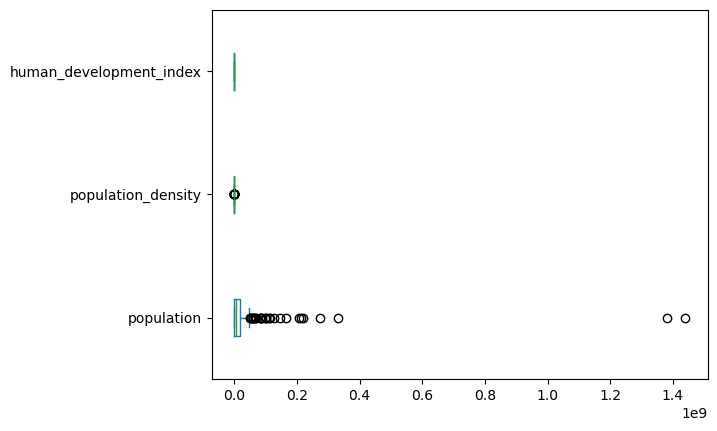


 Epidemiology 

 Descriptive statistics 
      new_confirmed new_deceased new_recovered   new_tested       year  \
count     227877.00    227877.00     227877.00    227877.00  227877.00   
mean        2670.05        28.36       1435.23     22213.61    2020.89   
std        16630.80       151.89      41890.33    158713.13       0.79   
min       -32952.00      -446.00  -10016828.00  -5147672.00    2020.00   
25%            0.00         0.00          0.00         0.00    2020.00   
50%           25.00         0.00          0.00         0.00    2021.00   
75%          507.00         6.00          0.00      2349.00    2022.00   
max      1235521.00     11447.00    9967355.00  35855632.00    2022.00   

           month  
count  227877.00  
mean        6.06  
std         3.31  
min         1.00  
25%         3.00  
50%         6.00  
75%         9.00  
max        12.00  

 Column data types 
location_key     string[python]
new_confirmed           float64
new_deceased            float64
new

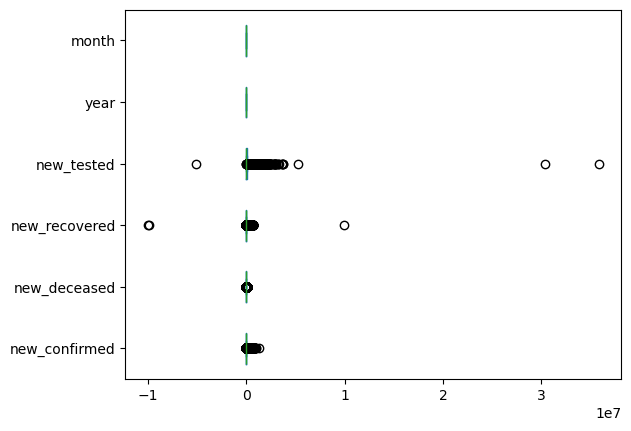


 Column outliers:   new_confirmed
         location_key  new_confirmed
22135              AR        59867.0
22136              AR        64004.0
22140              AR       107298.0
22141              AR       129265.0
22142              AR       148352.0
...               ...            ...
12467168           VN        90228.0
12467169           VN        65097.0
12467176           VN        73934.0
12467287           VN       404846.0
12467289           VN       156169.0

[2295 rows x 2 columns]

 Column outliers:   new_deceased
         location_key  new_deceased
21893              AR         497.0
21895              AR         487.0
21906              AR         497.0
21909              AR         537.0
21910              AR         515.0
...               ...           ...
12473830           ZA         555.0
12473838           ZA         573.0
12473844           ZA         553.0
12473852           ZA         516.0
12473986           ZA         551.0

[3097 rows x 2 columns]

 Col

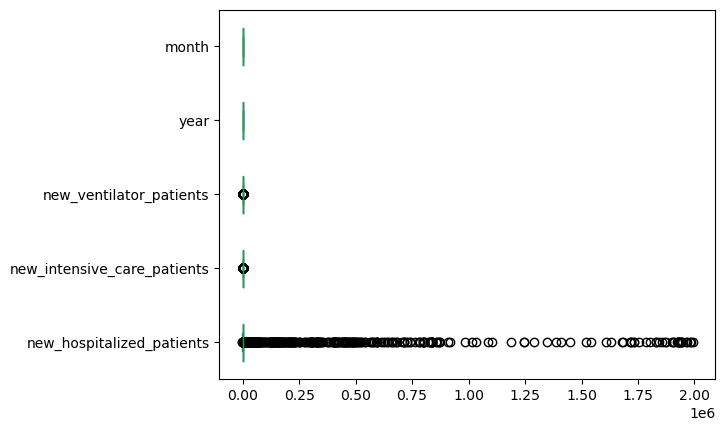


 Column outliers:   new_hospitalized_patients
        location_key  new_hospitalized_patients
1259445           JP                   344062.0
1259446           JP                   375697.0
1259447           JP                   415806.0
1259448           JP                   459980.0
1259449           JP                   503133.0
...              ...                        ...
1259675           JP                   983042.0
1259676           JP                   916610.0
1259677           JP                   871058.0
1259678           JP                   831000.0
1259679           JP                   804414.0

[178 rows x 2 columns]

 Column outliers:   new_intensive_care_patients
        location_key  new_intensive_care_patients
385960            BR                        698.0
385961            BR                        698.0
385962            BR                        714.0
385963            BR                        719.0
385964            BR                        717.0
... 

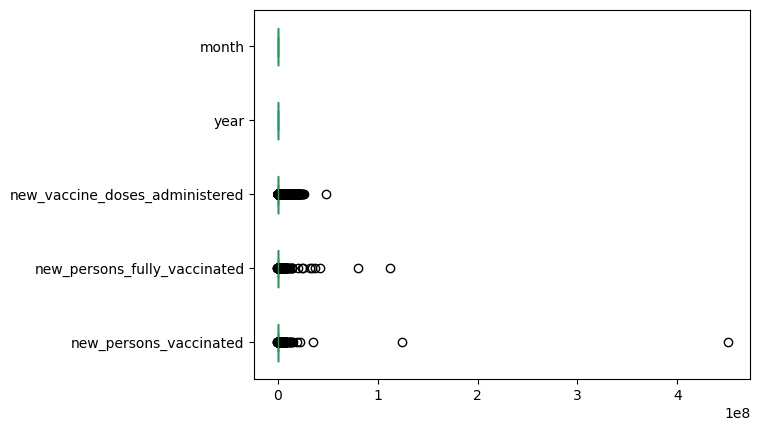


 Column outliers:   new_persons_vaccinated
       location_key  new_persons_vaccinated
247114           BD               6625123.0
247164           BD              12420904.0
247180           BD              19330896.0
297793           CN             450500000.0
297804           CN              22500000.0
297878           CN             124158000.0
297917           CN              34967000.0
298424           CO               7664236.0
329493           ET              13730462.0
660782           IN               8203530.0
660787           IN               6893275.0
660799           IN               7494156.0
660820           IN               8174273.0
660821           IN              10096011.0
660830           IN               9865786.0
660841           IN               6460721.0
660843           IN               7928444.0
660844           IN               7453586.0
660848           IN              12666048.0
660854           IN               8141709.0
660855           IN             

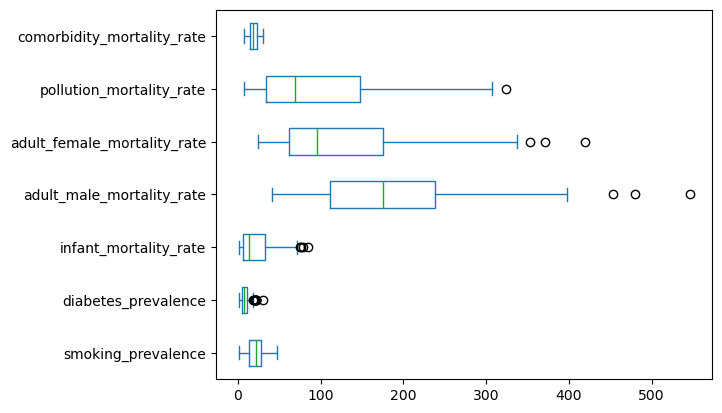


 Economy 

 Descriptive statistics 
                 gdp_usd gdp_per_capita_usd
count             203.00             203.00
mean     427140770724.73           17989.09
std     1890008781777.86           26649.15
min          47271463.00             261.00
25%        6236429369.00            2257.50
50%       27591261663.00            6966.00
75%      212445406771.50           23192.50
max    21374418877706.00          185829.00

 Column data types 
location_key          string[python]
gdp_usd                      float64
gdp_per_capita_usd           float64
dtype: object

 Numeric columns 
Index(['gdp_usd', 'gdp_per_capita_usd'], dtype='object')

 Boxplot 


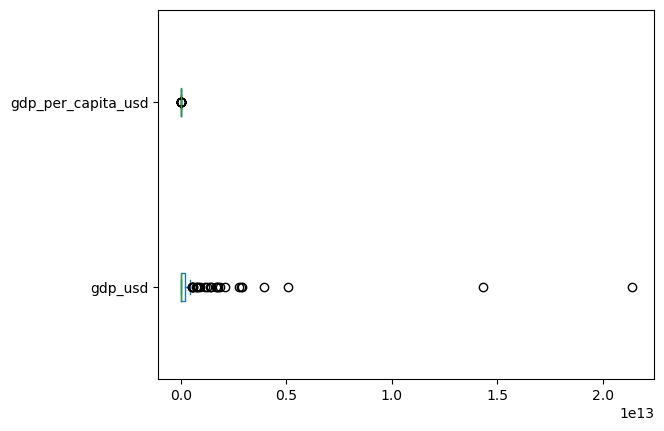


 Column outliers:   gdp_usd
    location_key       gdp_usd
72            CN  1.434290e+13
392           US  2.137442e+13

 Column outliers:   gdp_per_capita_usd
    location_key  gdp_per_capita_usd
258           LI            173356.0
263           LU            116348.0
267           MC            185829.0


In [27]:
for key,values in data.items():
    print("\n\033[1m", key.title(), "\033[0m")
    #display descriptive statistics
    print("\n\033[1m", 'Descriptive statistics', "\033[0m")
    print(data[key].describe().applymap("{0:.2f}".format))
    #display column data types
    print("\n\033[1m", 'Column data types', "\033[0m")
    print(data[key].dtypes)
    numeric_columns_index = [i for i,t in enumerate(data[key].dtypes) if str(t).startswith('float')]
    #display numeric columns
    print("\n\033[1m", 'Numeric columns', "\033[0m")
    numeric_columns = data[key].dtypes.iloc[numeric_columns_index].index
    print(numeric_columns)
    #display boxplots of numeric columns
    print("\n\033[1m", 'Boxplot', "\033[0m")
    data[key].plot.box(vert=False)
    plt.show()
    #display outliers of numeric columns
    data_z_score = stats.zscore(data[key][numeric_columns])
    for col in numeric_columns:        
        outliers = data[key][['location_key',col]][(data_z_score[col] >= 3) | (data_z_score[col] <= -3)]
        if len(outliers) > 0:
            print("\n\033[1m", 'Column outliers: ', "\033[0m", col)
            print(outliers)

The numeric columns of the **epidemiology**, **hospitalization**, and **epidemiology** datasets seem to have many outliers, but since many rows have zero values, any large value is seen as a outlier.

The **population** column of the **demographics** dataset also seem to have two outliers, but these data are for the two most populous countries in the world, China and India, whose population are both in the billion people range, therefore the high values seem valid.

The **gdp_usd** column of the **economy** dataset also seem to have two outliers, but these data are for the two countries with the largest economies in the world, USA and China, therefore the high values seem valid.

## <a id='datagrouping'></a> Data grouping

To simplify the analysis, group the data by **location_key**, **year**, and **month** for the following datasets with date data: **epidemiology**, **hospitalizations**, **vaccinations**.

In [28]:
for key,values in data.items():
    if data[key].columns.isin(['year']).any():        
        print("\n\033[1m", key.title(), "\033[0m")
        basic_columns = ['year','month','location_key']
        colums_df = [col for col in data[key].columns if col not in basic_columns]
        data[key] = data[key].groupby(basic_columns)[colums_df].sum().reset_index()
        print(data[key]) 


 Epidemiology 
      year  month location_key  new_confirmed  new_deceased  new_recovered  \
0     2020      1           AD            0.0           0.0            0.0   
1     2020      1           AE            9.0           0.0            0.0   
2     2020      1           AF            0.0           0.0            0.0   
3     2020      1           AG            0.0           0.0            0.0   
4     2020      1           AI            0.0           0.0            0.0   
...    ...    ...          ...            ...           ...            ...   
7642  2022      9           YE            6.0           0.0            0.0   
7643  2022      9           YT           66.0           0.0            0.0   
7644  2022      9           ZA         2747.0          21.0            0.0   
7645  2022      9           ZM          407.0           1.0            0.0   
7646  2022      9           ZW          195.0           0.0            0.0   

      new_tested  
0            0.0  
1        

***

# <a id='combining'></a> Combining the Datasets

## <a id='unique'></a> Checking for unique values

Check that **location_key** column only has unique values for each row to ensure that no country is duplicated for the following datasets: **demographics**, **health**, **economy**.

In [29]:
for key,values in data.items():
    if data[key].columns.isin(['year']).any() == False:        
        print("\n\033[1m", key.title(), "\033[0m")
        key_column = 'location_key'
        print(f"Unique column '{key_column}': {not data[key]['location_key'].duplicated().any()}")   



 Demographics 
Unique column 'location_key': True

 Health 
Unique column 'location_key': True

 Economy 
Unique column 'location_key': True


## <a id='combining2'></a> Combining the datasets

Using the unique identifier **location_key**, merge all six datasets into one using a **left join**. The **epidemiology** dataset is chosen as the main dataset since it is the heart of this study - it includes all data on COVID-19 cases, deaths, recoveries, and tests.

In [32]:
#main dataset
complete_df = data['epidemiology']
#print(len(data['epidemiology']))

for key in [key for key in data.keys() if key not in ['epidemiology']]:
    #if dataset has a year column, use the three keys to do the merge 
    keys_with_date = ['location_key','year','month']
    keys_without_date = ['location_key']
    if data[key].columns.isin(['year']).any():        
        complete_df = complete_df.merge(data[key], on=keys_with_date, how="left")
    else:
        complete_df = complete_df.merge(data[key], on=keys_without_date, how="left")

print(f'Length of complete dataset: {len(complete_df)}')
print(f'Complete dataset:')
complete_df.head()

Length of complete dataset: 7647
Complete dataset:


,year,month,location_key,new_confirmed,new_deceased,new_recovered,new_tested,population,population_density,human_development_index,new_hospitalized_patients,new_intensive_care_patients,new_ventilator_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_vaccine_doses_administered,smoking_prevalence,diabetes_prevalence,infant_mortality_rate,adult_male_mortality_rate,adult_female_mortality_rate,pollution_mortality_rate,comorbidity_mortality_rate,gdp_usd,gdp_per_capita_usd
0,2020,1,AD,0.0,0.0,0.0,0.0,77265.0,164.394,0.858,NaN,NaN,NaN,NaN,NaN,NaN,33.5,7.7,2.7,NaN,NaN,NaN,NaN,3.154058e+09,40886.0
1,2020,1,AE,9.0,0.0,0.0,258.0,9890400.0,118.306,0.863,NaN,NaN,NaN,NaN,NaN,NaN,28.9,16.3,6.5,69.555,44.863,54.7,16.8,4.211423e+11,43103.0
2,2020,1,AF,0.0,0.0,0.0,0.0,38928341.0,59.627,0.498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.2,47.9,237.554,192.532,211.1,29.8,1.910135e+10,502.0
3,2020,1,AG,0.0,0.0,0.0,0.0,97928.0,222.564,0.780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.1,5.0,126.917,83.136,29.9,22.6,1.727759e+09,17790.0
4,2020,1,AI,0.0,0.0,0.0,0.0,15002.0,166.689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Fill the missing values in the complete dataset with zero in the columns for the following datasets: **vaccinations**, **hospitalizations**, **epidemiology**.

In [33]:
columns_to_fill = columns_to_fill_vaccinations+ columns_to_fill_hospitalizations + columns_to_fill_epidemiology

complete_df[columns_to_fill] = complete_df[columns_to_fill].fillna(0)
complete_df.head()

,year,month,location_key,new_confirmed,new_deceased,new_recovered,new_tested,population,population_density,human_development_index,new_hospitalized_patients,new_intensive_care_patients,new_ventilator_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_vaccine_doses_administered,smoking_prevalence,diabetes_prevalence,infant_mortality_rate,adult_male_mortality_rate,adult_female_mortality_rate,pollution_mortality_rate,comorbidity_mortality_rate,gdp_usd,gdp_per_capita_usd
0,2020,1,AD,0.0,0.0,0.0,0.0,77265.0,164.394,0.858,0.0,0.0,0.0,0.0,0.0,0.0,33.5,7.7,2.7,NaN,NaN,NaN,NaN,3.154058e+09,40886.0
1,2020,1,AE,9.0,0.0,0.0,258.0,9890400.0,118.306,0.863,0.0,0.0,0.0,0.0,0.0,0.0,28.9,16.3,6.5,69.555,44.863,54.7,16.8,4.211423e+11,43103.0
2,2020,1,AF,0.0,0.0,0.0,0.0,38928341.0,59.627,0.498,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.2,47.9,237.554,192.532,211.1,29.8,1.910135e+10,502.0
3,2020,1,AG,0.0,0.0,0.0,0.0,97928.0,222.564,0.780,0.0,0.0,0.0,0.0,0.0,0.0,NaN,13.1,5.0,126.917,83.136,29.9,22.6,1.727759e+09,17790.0
4,2020,1,AI,0.0,0.0,0.0,0.0,15002.0,166.689,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Display descriptive statistics of complete dataset:

In [34]:
complete_df.describe().applymap("{0:.2f}".format)

,year,month,new_confirmed,new_deceased,new_recovered,new_tested,population,population_density,human_development_index,new_hospitalized_patients,new_intensive_care_patients,new_ventilator_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_vaccine_doses_administered,smoking_prevalence,diabetes_prevalence,infant_mortality_rate,adult_male_mortality_rate,adult_female_mortality_rate,pollution_mortality_rate,comorbidity_mortality_rate,gdp_usd,gdp_per_capita_usd
count,7647.00,7647.00,7647.00,7647.00,7647.00,7647.00,7647.00,7647.00,7448.00,7647.00,7647.00,7647.00,7647.00,7647.00,7647.00,4818.00,6887.00,6369.00,6557.00,6590.00,6039.00,6039.00,6689.00,6689.00
mean,2020.91,6.09,79566.16,844.98,42769.13,661955.00,33483151.22,459.93,0.73,26463.66,124.39,0.56,619049.64,540458.77,1623810.57,21.63,8.37,21.38,186.17,122.64,92.21,18.88,427512146832.22,17911.39
std,0.79,3.31,458988.13,4215.28,630888.11,3621963.29,135678597.99,2263.63,0.15,841806.15,1785.38,14.91,6694730.25,4529801.66,14241865.31,9.69,4.72,19.38,93.20,80.99,71.74,5.59,1886863900830.29,26520.71
min,2020.00,1.00,-13341.00,0.00,-9906177.00,0.00,50.00,0.14,0.35,-6350.00,0.00,0.00,-518406.00,-109305.00,0.00,2.00,1.00,1.40,41.50,24.49,7.00,7.80,47271463.00,261.00
25%,2020.00,3.00,64.00,0.00,0.00,0.00,437483.00,36.19,0.61,0.00,0.00,0.00,0.00,0.00,0.00,14.00,5.40,6.10,110.63,61.84,33.50,14.80,5920000000.00,2229.00
50%,2021.00,6.00,1371.00,11.00,0.00,0.00,5518092.00,94.40,0.75,0.00,0.00,0.00,0.00,0.00,0.00,21.80,6.90,14.00,175.46,95.76,68.60,18.80,27591261663.00,6966.00
75%,2022.00,9.00,17217.50,195.00,0.00,86545.50,21413250.00,235.10,0.84,0.00,0.00,0.00,47507.00,33950.50,164093.00,28.00,10.70,32.70,238.33,176.15,149.00,22.90,217962048000.00,23246.00
max,2022.00,12.00,19597236.00,119560.00,18582607.00,66762647.00,1439323774.00,26338.26,0.98,58504041.00,76254.00,467.00,450500000.00,158433000.00,582241000.00,47.00,30.50,84.50,545.67,419.36,324.10,30.60,21374418877706.00,185829.00


It can be noted that values in some columns are negative, namely for the **new_confirmed**, **new_recovered**, **new_hospitalized_patients**, **new_persons_vaccinated**, and **new_persons_fully_vaccinated** columns. From the datasets' metadata, it was noted that the negative values indicate a correction or an adjustment in the way they were measured (e.g., a case might have been incorrectly flagged as recovered in one date so it was subtracted from the following date).

***

# <a id='correlation'></a> Finding Correlations 

Display the correlation among all variables in the complete dataset:

In [35]:
correlations = complete_df.corr(numeric_only=True)
correlations

,year,month,new_confirmed,new_deceased,new_recovered,new_tested,population,population_density,human_development_index,new_hospitalized_patients,new_intensive_care_patients,new_ventilator_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_vaccine_doses_administered,smoking_prevalence,diabetes_prevalence,infant_mortality_rate,adult_male_mortality_rate,adult_female_mortality_rate,pollution_mortality_rate,comorbidity_mortality_rate,gdp_usd,gdp_per_capita_usd
year,1.000000e+00,-1.703575e-01,0.105493,-0.010787,0.029103,0.036014,-0.000124,0.006293,0.000102,0.036748,-0.020044,-0.036365,0.030746,0.051277,0.051586,-2.182099e-15,-0.000206,4.142650e-15,-0.000321,-0.000342,8.914765e-18,-6.790802e-15,-0.000177,0.001611
month,-1.703575e-01,1.000000e+00,-0.035098,0.009174,-0.007715,0.014260,0.000201,-0.006011,-0.000995,-0.000510,-0.005529,0.013780,0.022171,0.042180,0.019011,-9.858694e-17,0.000749,9.890681e-17,0.001262,0.001090,-5.224188e-16,-4.123380e-16,0.000138,-0.001928
new_confirmed,1.054925e-01,-3.509777e-02,1.000000,0.599943,0.225866,0.621667,0.242892,-0.019450,0.123464,0.195622,0.187289,0.204710,0.155463,0.155822,0.155197,3.787263e-02,-0.006209,-1.218362e-01,-0.102248,-0.102844,-1.310603e-01,-1.315623e-01,0.428293,0.085296
new_deceased,-1.078667e-02,9.173957e-03,0.599943,1.000000,0.105902,0.594001,0.302096,-0.029141,0.093054,0.035304,0.493268,0.378479,0.224851,0.200161,0.183411,-7.761566e-04,0.016614,-1.137516e-01,-0.065635,-0.081867,-1.220806e-01,-7.103396e-02,0.456461,0.035881
new_recovered,2.910267e-02,-7.714933e-03,0.225866,0.105902,1.000000,0.200534,0.025088,-0.010653,0.063775,0.000383,0.223694,-0.002546,0.025595,0.034512,0.023104,6.894514e-02,-0.039431,-6.285266e-02,-0.054345,-0.055387,-7.941347e-02,-9.352743e-02,0.075172,0.045288
new_tested,3.601361e-02,1.425964e-02,0.621667,0.594001,0.200534,1.000000,0.394467,-0.019298,0.123248,0.021362,0.093124,0.327234,0.327939,0.379878,0.292753,2.156496e-02,0.008065,-1.120626e-01,-0.106155,-0.093578,-1.043259e-01,-1.182691e-01,0.496280,0.107542
population,-1.235742e-04,2.011370e-04,0.242892,0.302096,0.025088,0.394467,1.000000,-0.024589,-0.040168,0.022730,0.067615,0.082364,0.374968,0.468515,0.562970,-4.655987e-02,0.021566,5.011672e-03,-0.037113,-0.014014,9.071138e-02,2.372063e-02,0.578290,-0.063864
population_density,6.293002e-03,-6.011230e-03,-0.019450,-0.029141,-0.010653,-0.019298,-0.024589,1.000000,0.183106,-0.001787,-0.012830,-0.007031,-0.007946,-0.009719,-0.010369,-1.505555e-02,-0.092985,-1.064937e-01,-0.176806,-0.149412,-1.067918e-01,-1.867051e-01,-0.022254,0.481579
human_development_index,1.018002e-04,-9.952456e-04,0.123464,0.093054,0.063775,0.123248,-0.040168,0.183106,1.000000,0.038954,0.032264,0.047477,0.001007,0.003861,0.011069,3.794039e-01,0.157451,-8.864135e-01,-0.762990,-0.830490,-8.694909e-01,-5.782739e-01,0.186735,0.645720
new_hospitalized_patients,3.674824e-02,-5.095778e-04,0.195622,0.035304,0.000383,0.021362,0.022730,-0.001787,0.038954,1.000000,0.005989,0.007567,0.004840,0.006706,0.032040,1.759587e-03,-0.017743,-3.428874e-02,-0.042040,-0.035334,-3.936731e-02,-6.413066e-02,0.089242,0.028514


<Axes: >

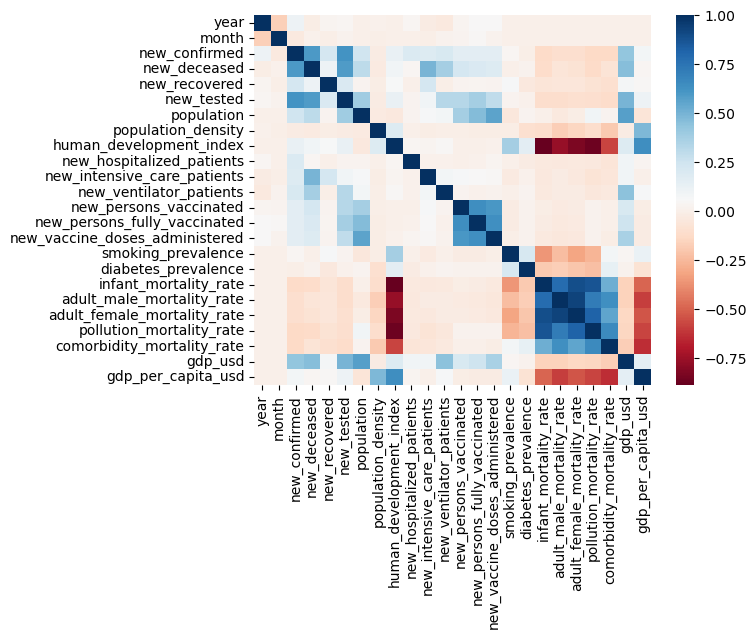

In [36]:
sns.heatmap(correlations, cmap ='RdBu')

## <a id='analysis'></a> Correlation analysis

Some notable observations from the above correlation heatmap:
1. *Strong negative correlations*

- **human development index** and **mortality rates** (infant, male adult, female adult, pollution, comorbidity) - highly developed countries usually have lower mortality rates since higher income, better quality of education, and access to quality healthcare contribute to higher life expectancy.

2. *Moderate positive correlations*
- **new_intensive_care_patients** and **new_deceased** - this relationship is expected since patients admitted in the ICU have severe cases of COVID-19 infection, thus we would expect the number of deceased to increase as the number of people admitted to ICU increases.

- **new_tested** with **new_confirmed**, **new_deceased** - this relationship is expected since as the number of COVID-19 tests conducted increases, there will be more infections and deaths confirmed to be caused by COVID-19 instead of other diseases.

- **new_persons_fully_vaccinated** and **new_vaccine_doses_administered** - as the number of COVID-19 vaccines administered increases, the number of fully-vaccinated individuals also increases.

- **gdp_usd** with **new_confirmed**, **new_deceased**, **new_tested**, **new_ventilator_patients**, **new_persons_vaccinated**, **new_persons_fully_vaccinated**, **new_vaccine_doses_administered** - countries with high GDP (i.e., countries with strong and developing economies) typically have better access to COVID-19 testing facilities and COVID-19 vaccines, therefore we see higher numbers for these countries compared to countries with low GDP, which may actually have more actual cases but have limited access to these facilities and vaccines, but have lower recorded numbers

3. *Weak negative correlation*
- **population density** with **positive cases**, **hospitalized cases**, **vaccinated cases**, and **mortality rates** - this seems counterintuitive since we would expect a country with high population density to have more positive, hospitalized, vaccinated, and death cases. Different trends may be observed if we observe the correlations on a more detailed level (i.e. look at a subset of countries instead of the dataset as a whole). Other factors may also come into play to affect the level of COVID-19 exposure, such as the efficiency of a country's COVID response and socioeconomic factors (isolated vs apartment dwelling).